In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import json
import h5py
import glob

from SiPMStudio.analysis.dark import amp_dt, all_dts, cross_talk_frac, gain
from matplotlib.colors import LogNorm

from scipy.signal import find_peaks
from scipy.stats import linregress

In [2]:
USERDIR = os.path.join("/global", "cfs", "projectdirs", "legend", "users", "nickruof")
DATADIR = os.path.join(USERDIR, "test_stand", "ketek_ln_test_02022022")
file_list = glob.glob(os.path.join(DATADIR, "t2", "*.h5"))

In [3]:
file_list

['/global/cfs/projectdirs/legend/users/nickruof/test_stand/ketek_ln_test_02022022/t2/t2_ketek_ln_test_27_1.h5',
 '/global/cfs/projectdirs/legend/users/nickruof/test_stand/ketek_ln_test_02022022/t2/t2_ketek_ln_test_27.h5']

In [4]:
idx = 1

In [5]:
peaks_json = None
with open(os.path.join(DATADIR, "ketek_ln_reprocs_norm.json"), "r") as json_file:
    peaks_json = json.load(json_file)

In [6]:
head, file_name = os.path.split(file_list[idx])
peaks = peaks_json["processes"]["normalize_charge"][file_name]["peak_locs"]
errors = peaks_json["processes"]["normalize_charge"][file_name]["peak_errors"]

In [7]:
gain(peaks, errors)

827767.6126480205

In [8]:
test_file = h5py.File(file_list[idx], "r")
bias = test_file["bias"][()]
dt = test_file["dt"][()]
timetags = test_file["timetag"][:]
blr_wf = test_file["/processed/channels/sipm/blr_wf"][:]
wf_len = test_file["/processed/channels/sipm/wf_len"][()]
adc_v = test_file["/processed/channels/sipm/adc_to_v"][()]
charges = test_file["/processed/channels/sipm/charge"][:]
norm_charges = test_file["/processed/channels/sipm/norm_charge"][:]

In [9]:
test_file.close()

In [10]:
wf_time = np.arange(0, dt*wf_len, dt)

In [11]:
def plot_waveforms(ax, time, waveforms, num=50, offset=0):
    for i in range(offset, num+offset):
        ax.plot(time, waveforms[i])
    ax.set_xlabel("Time (ns)")
    ax.set_ylabel("Amplitude (mV)")
    
def plot_charge(ax, charges, bins=1000, x_range=None):
    ax.hist(charges, bins=bins, range=x_range, histtype="stepfilled", alpha=0.15, color=sns.color_palette()[0])
    ax.hist(charges, bins=bins, range=x_range, histtype="step", color=sns.color_palette()[0])
    ax.set_xlabel("P.E.")
    ax.set_ylabel("Counts")
    
def plot_dts(ax, dts, bins=1000, x_range=None):
    ax.hist(dts, bins=bins, range=x_range, histtype="stepfilled", alpha=0.15, color=sns.color_palette()[0])
    n, bins, patches = ax.hist(dts, bins=bins, range=x_range, histtype="step", color=sns.color_palette()[0])
    ax.set_xlabel("Inter-times (ns)")
    ax.set_ylabel("Count")
    return n, bins
    
def plot_amp_dt(fig, ax, dts, amps, bins=[1000, 1000], x_range=[10, 5e3], y_range=[0, 600]):
    x_bins = np.logspace(np.log10(x_range[0]), np.log10(x_range[1]), bins[0])
    y_bins = np.linspace(y_range[0], y_range[1], bins[1])
    h, x, y, im = ax.hist2d(dts, amps, bins=[x_bins, y_bins], norm=LogNorm())
    ax.set_xlabel("Inter-times (ns)")
    ax.set_ylabel("Amplitude (mV)")
    ax.set_xscale("log")
    fig.colorbar(im, ax=ax)
    
def fit_exp(x, y):
    x_new = x[y > 0]
    y_new = y[y > 0]
    ln_y = np.log(y_new)
    slope, intercept, r, p, stderr = linregress(x_new, ln_y)
    scale = (1 / (1e-9*1e3))
    return abs(slope)*scale, stderr*scale, slope, intercept

In [12]:
FIGSIZE=(12, 8)

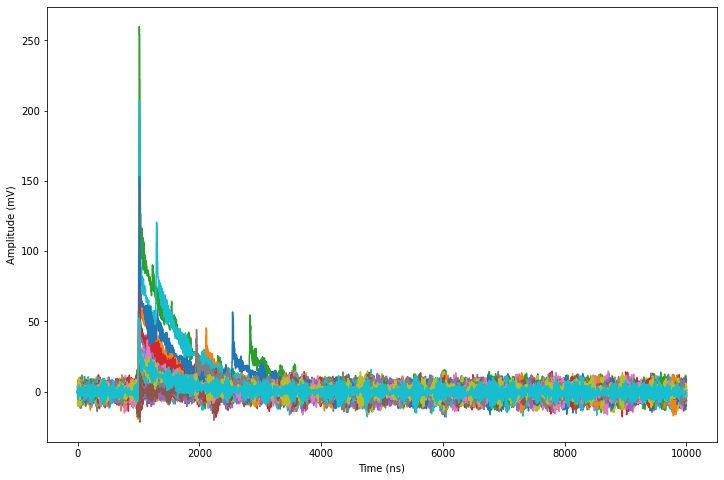

In [13]:
fig, ax = plt.subplots(figsize=FIGSIZE)
plot_waveforms(ax, wf_time, blr_wf*adc_v*1e3)
if not os.path.exists(os.path.join(DATADIR, "plots", "waveforms")):
    os.makedirs(os.path.join(DATADIR, "plots", "waveforms"))
plt.savefig(os.path.join(DATADIR, "plots", "waveforms", f"waveforms_{bias}.png"), dpi=600)

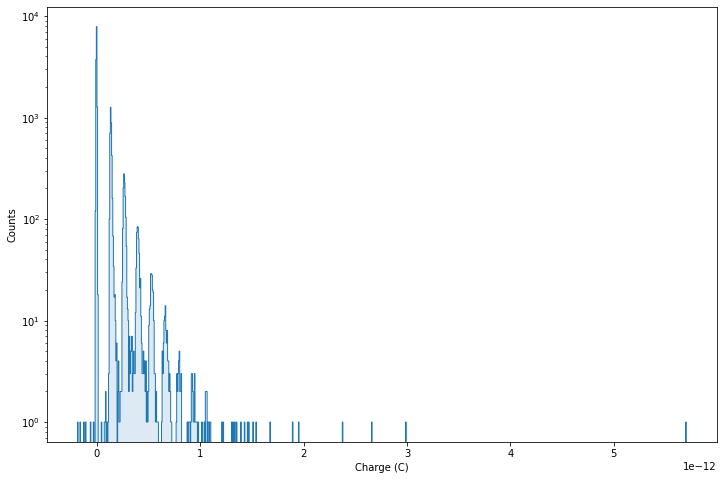

In [14]:
fig, ax = plt.subplots(figsize=FIGSIZE)
plot_charge(ax, charges)
ax.set_xlabel("Charge (C)")
ax.set_yscale("log")
if not os.path.exists(os.path.join(DATADIR, "plots", "pe_spectrums")):
    os.makedirs(os.path.join(DATADIR, "plots", "pe_spectrums"))
plt.savefig(os.path.join(DATADIR, "plots", "pe_spectrums", f"charge_spec_{bias}.png"), dpi=600)

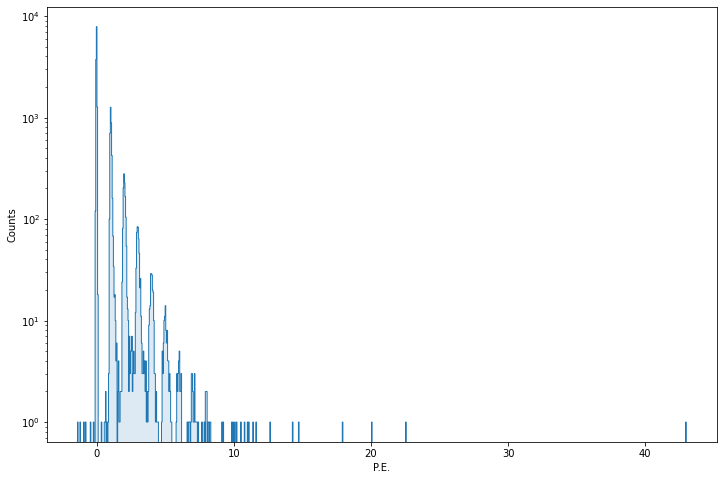

In [15]:
fig, ax = plt.subplots(figsize=FIGSIZE)
plot_charge(ax, norm_charges)
ax.set_yscale("log")
plt.savefig(os.path.join(DATADIR, "plots", "pe_spectrums", f"norm_spec_{bias}.png"), dpi=600)

In [16]:
wf_dts, wf_amps, wf_ids = amp_dt(timetags, blr_wf*adc_v*1e3, dt, norm_charges, trig_time=1000, height=40, distance=100, width=4)

100%|██████████| 5779/5779 [00:01<00:00, 5198.40it/s]


In [17]:
wf_dts.shape

(3376,)

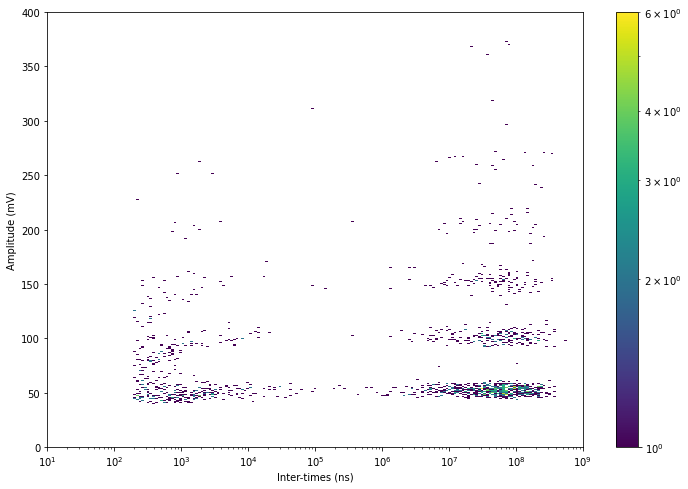

In [18]:
fig, ax = plt.subplots(figsize=FIGSIZE)
plot_amp_dt(fig, ax, wf_dts, wf_amps, bins=[200, 1000], x_range=[10, 1e9], y_range=[0, 400])

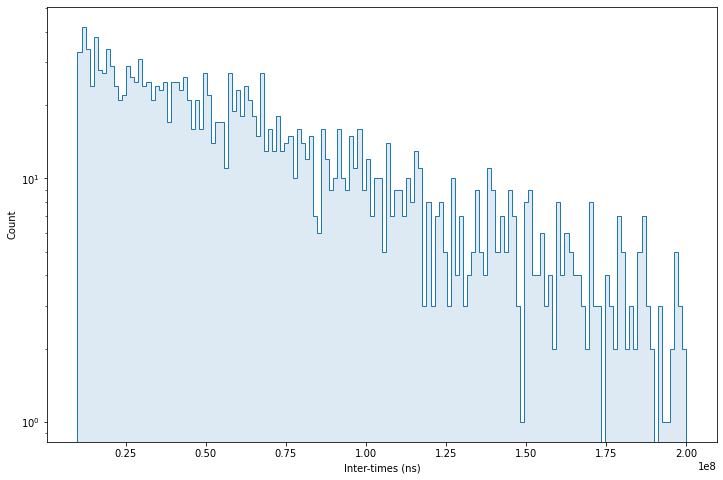

In [33]:
lower_time = 1e7
upper_time = 2e8
dt_cut = (wf_dts > lower_time) & (wf_dts < upper_time)

lower_amp = 40
upper_amp = 400
amp_cut = (wf_amps > lower_amp) & (wf_amps < upper_amp)

fig, ax = plt.subplots(figsize=FIGSIZE)
n, bins = plot_dts(ax, wf_dts[amp_cut & dt_cut], x_range=[lower_time, upper_time], bins=150)
ax.set_yscale("log")

In [35]:
bin_centers = (bins[1:] + bins[:-1]) / 2
rate, error, slope, intercept = fit_exp(bin_centers, n)

In [36]:
inter_times = np.linspace(0, upper_bound, 100)
exp_func = np.exp(intercept + slope*inter_times)
label = "Hz"

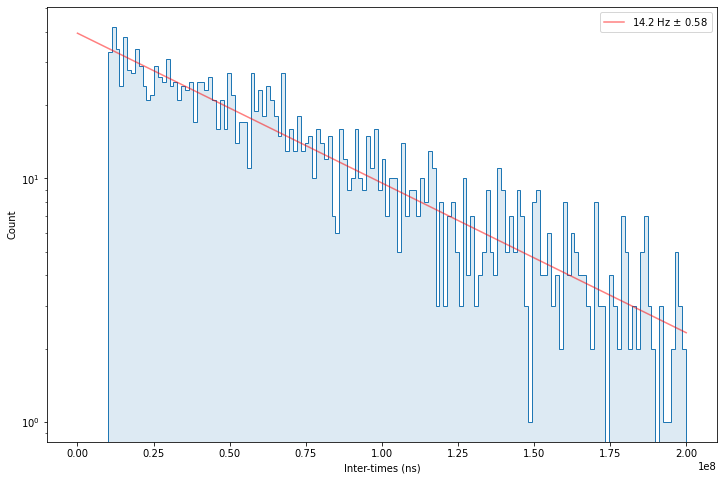

In [38]:
fig, ax = plt.subplots(figsize=FIGSIZE)
n, bins = plot_dts(ax, wf_dts[amp_cut & dt_cut], x_range=[lower_bound, upper_bound], bins=150)
if label == "kHz":
    ax.plot(inter_times, exp_func, color="red", alpha=0.5, label=rf"{round(rate, 1)} kHz $\pm$ {round(error, 2)}")
elif label == "Hz":
    ax.plot(inter_times, exp_func, color="red", alpha=0.5, label=rf"{round(rate*1e3, 1)} Hz $\pm$ {round(error*1e3, 2)}")
ax.legend()
ax.set_yscale("log")
if not os.path.exists(os.path.join(DATADIR, "plots", "dark_counts")):
    os.makedirs(os.path.join(DATADIR, "plots", "dark_counts"))
plt.savefig(os.path.join(DATADIR, "plots", "dark_counts", f"dcr_{bias}.png"), dpi=600)